## Cross-Validation with Linear Regression

This notebook was an exercise to do cross-validation (CV) with linear regression as an example (it is heavily used in almost all modelling techniques such as decision trees, SVM etc.).

This notebook is divided into the following parts:
0. Experimenting to understand overfitting
1. Building a linear regression model without cross-validation
2. Problems in the current approach
3. Cross-validation: A quick recap
4. Cross-validation in `sklearn`:
    - 4.1 K-fold CV 
    - 4.2 Hyperparameter tuning using CV
    - 4.3 Other CV schemes



## 0. Experiments to Understand Overfitting

In this section, we'll run some experiments using polynomial regression.

In [2]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [3]:
# import Housing.csv
housing = pd.read_csv('Housing.csv')
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [6]:
# number of observations 
len(housing.index)

545

For the first experiment, we'll do regression with only one feature. Let's filter the data so it only contains `area` and `price`.

In [7]:
# filter only area and price
df = housing.loc[:, ['area', 'price']]
df.head()

,area,price
0,7420,13300000
1,8960,12250000
2,9960,12250000
3,7500,12215000
4,7420,11410000


In [8]:
# recaling the variables (both)
df_columns = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

# rename columns (since now its an np array)
df = pd.DataFrame(df)
df.columns = df_columns

df.head()

,area,price
0,0.396564,1.000000
1,0.502405,0.909091
2,0.571134,0.909091
3,0.402062,0.906061
4,0.396564,0.836364


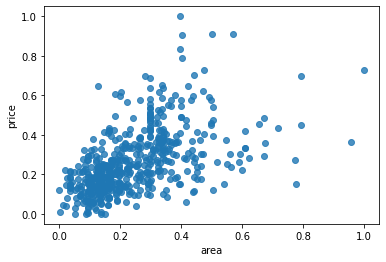

In [9]:
# visualise area-price relationship
sns.regplot(x="area", y="price", data=df, fit_reg=False)

In [10]:
# split into train and test
df_train, df_test = train_test_split(df, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 10)
print(len(df_train))
print(len(df_test))

381
164


In [11]:
# split into X and y for both train and test sets
# reshaping is required since sklearn requires the data to be in shape
# (n, 1), not as a series of shape (n, )
X_train = df_train['area']
X_train = X_train.values.reshape(-1, 1)
y_train = df_train['price']

X_test = df_test['area']
X_test = X_test.values.reshape(-1, 1)
y_test = df_test['price']

### Polynomial Regression

In polynomial regression of degree $n$, we fit a curve of the form:

$y = \beta_0 + \beta_1 x_1 + \beta_2x_1^2 + \beta_3x_1^3 ... + \beta_nx_1^n$

In the experiment below, I have fitted polynomials of various degrees on the housing data and compared their performance on train and test sets.

In sklearn, polynomial features can be generated using the `PolynomialFeatures` class. Also, to perform `LinearRegression` and `PolynomialFeatures` in tandem, I will use the module `sklearn_pipeline` - it basically creates the features and feeds the output to the model (in that sequence).

In [13]:
len(X_train)

381

Let's now predict the y labels (for both train and test sets) and store the predictions in a table. Each row of the table is one data point, each column is a value of $n$ (degree).

<table style="width:100%">
  <tr>
    <th>   </th>
    <th>degree-1</th>
    <th>degree-2</th> 
    <th>degree-3</th>
    <th>...</th>
    <th>degree-n</th>
  </tr>
  <tr>
    <th>x1</th>
  </tr>
  <tr>
    <th>x2</th>
  </tr>
   <tr>
    <th>x3</th>
    </tr>
    <tr>
    <th>...</th>
    </tr>
    <tr>
    <th>xn</th>
    </tr>
</table>

In [14]:
# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)
    

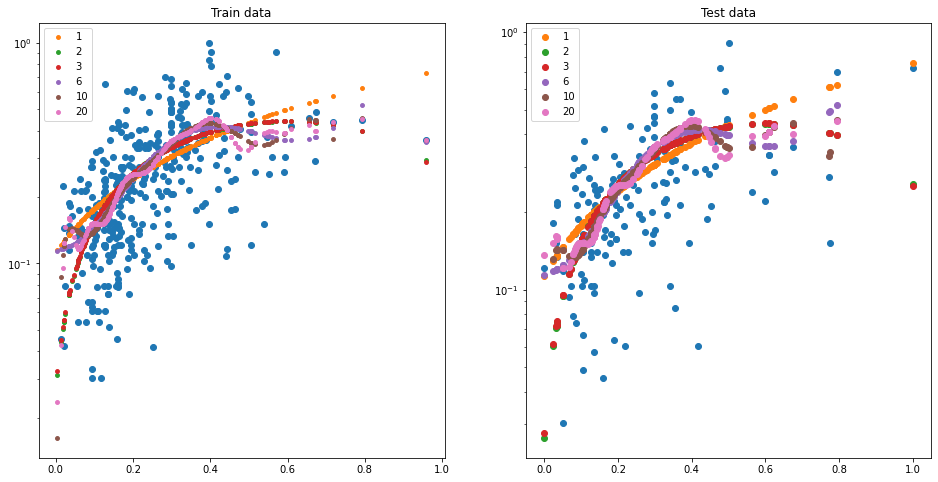

In [15]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [16]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

R-squared values: 

Polynomial degree 1: train score=0.29, test score=0.25
Polynomial degree 2: train score=0.34, test score=0.22
Polynomial degree 3: train score=0.34, test score=0.22
Polynomial degree 6: train score=0.36, test score=0.11
Polynomial degree 10: train score=0.37, test score=-108.76
Polynomial degree 20: train score=0.38, test score=-301329899923.94


## 1. Building a Model Without Cross-Validation

Let's now build a multiple regression model. First, let's build a vanilla MLR model without any cross-validation etc. 

In [17]:
# data preparation

# list of all the "yes-no" binary categorical variables
# we'll map yes to 1 and no to 0
binary_vars_list =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# applying the function to the housing variables list
housing[binary_vars_list] = housing[binary_vars_list].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [18]:
# 'dummy' variables
# get dummy variables for 'furnishingstatus' 
# also, drop the first column of the resulting df (since n-1 dummy vars suffice)
status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)
status.head()

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [19]:
# concat the dummy variable df with the main df
housing = pd.concat([housing, status], axis = 1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [20]:
# 'furnishingstatus' since we alreday have the dummy vars
housing.drop(['furnishingstatus'], axis = 1, inplace = True)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


#### Splitting Into Train and Test

In [21]:
# train-test 70-30 split
df_train, df_test = train_test_split(housing, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [22]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.247651,0.084536,0.333333,0.000000,0.333333,1,0,0,0,0,0.000000,1,1,0
54,0.530201,0.298969,0.333333,0.333333,0.333333,1,1,0,0,1,0.333333,0,1,0
171,0.328859,0.592371,0.333333,0.000000,0.000000,1,0,0,0,0,0.333333,1,1,0
244,0.261745,0.252234,0.333333,0.000000,0.333333,1,1,1,0,0,0.000000,1,1,0
268,0.245638,0.226804,0.666667,0.000000,0.333333,1,0,0,0,1,0.000000,0,1,0


In [23]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

Note that the test set has not been rescaled yet, which we'll need to do later while making predictions.

#### Using RFE 

Now, I have 13 predictor features. To build the model using RFE, I need to tell RFE how many features we want in the final model. It then runs a feature elimination algorithm. 

Note that the number of features to be used in the model is a **hyperparameter**.

In [24]:
# num of max features
len(X_train.columns)

13

In [25]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)             
rfe = rfe.fit(X_train, y_train)

In [26]:
# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', False, 3),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 4),
 ('unfurnished', False, 2)]

In [27]:
# predict prices of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5812051458999572


In [28]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5350445027578822


## 2. Problems in the Current Approach

In train-test split, we have three options:
1. **Simply split into train and test**: But that way tuning a hyperparameter makes the model 'see' the test data (i.e. knowledge of test data leaks into the model)
2. **Split into train, validation, test sets**: Then the validation data would eat into the training set
3. **Cross-validation**: Split into train and test, and train multiple models by sampling the train set. Finally, just test once on the test set.


## 3. Cross-Validation: A Quick Recap

The following figure illustrates k-fold cross-validation with k=4. There are some other schemes to divide the training set, we'll look at them briefly later.

<img src="cv.png" title="K-Fold Cross Validation" />

## 4. Cross-Validation in sklearn

Let's now experiment with k-fold CV.

### 4.1 K-Fold CV

In [29]:
# k-fold CV (using all the 13 variables)
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores      

array([0.6829775 , 0.69324306, 0.6762109 , 0.61782891, 0.59266171])

In [30]:
# the other way of doing the same thing (more explicit)

# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores   

array([0.59930574, 0.71307628, 0.61325733, 0.62739077, 0.6212937 ])

In [33]:
# can tune other metrics, such as MSE
scores = cross_val_score(lm, X_train, y_train, cv=5)
scores

array([0.6829775 , 0.69324306, 0.6762109 , 0.61782891, 0.59266171])

### 4.2 Hyperparameter Tuning Using Grid Search Cross-Validation

A common use of cross-validation is for tuning hyperparameters of a model. The most common technique is what is called **grid search** cross-validation.


<img src="grid_search_image.png"/>

In [34]:
# number of features in X_train
len(X_train.columns)

13

In [35]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    1.0s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             return_train_score=True, scoring='r2', verbose=1)

In [36]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.021118,7.525205e-03,0.003601,0.001200,1,{'n_features_to_select': 1},0.172606,0.351721,0.206887,0.165910,...,0.243658,0.077627,13,0.302971,0.265961,0.280611,0.300768,0.269025,0.283867,0.015506
1,0.025946,2.000528e-02,0.003400,0.000801,2,{'n_features_to_select': 2},0.335665,0.428751,0.439969,0.505321,...,0.438360,0.058374,12,0.505799,0.489802,0.462091,0.474178,0.471907,0.480755,0.015355
2,0.012803,1.600504e-03,0.002800,0.000400,3,{'n_features_to_select': 3},0.421848,0.539257,0.491515,0.604426,...,0.516805,0.059902,11,0.568074,0.544917,0.542889,0.534685,0.542412,0.546596,0.011289
3,0.010803,4.000679e-04,0.002601,0.000490,4,{'n_features_to_select': 4},0.449487,0.567101,0.494461,0.600237,...,0.526272,0.053074,10,0.587523,0.564018,0.549490,0.541496,0.549291,0.558364,0.016296
4,0.011002,5.352484e-07,0.002401,0.000490,5,{'n_features_to_select': 5},0.494779,0.610200,0.492807,0.590812,...,0.541889,0.049257,8,0.620038,0.597033,0.584663,0.549413,0.589397,0.588109,0.022847
5,0.010002,6.311283e-04,0.002800,0.000401,6,{'n_features_to_select': 6},0.512477,0.628849,0.488411,0.527379,...,0.541063,0.048029,9,0.626959,0.603122,0.596348,0.606852,0.601063,0.606869,0.010602
6,0.009802,7.483410e-04,0.002600,0.000490,7,{'n_features_to_select': 7},0.568887,0.664093,0.552385,0.534634,...,0.577636,0.045006,7,0.658577,0.638501,0.630137,0.646285,0.638313,0.642363,0.009582
7,0.009002,1.239777e-06,0.002400,0.000490,8,{'n_features_to_select': 8},0.570639,0.665608,0.592323,0.550001,...,0.591795,0.039428,6,0.674146,0.640825,0.654028,0.658665,0.657277,0.656988,0.010651
8,0.007201,7.488769e-04,0.002601,0.000491,9,{'n_features_to_select': 9},0.578843,0.694189,0.606220,0.590777,...,0.615352,0.040767,4,0.676043,0.652605,0.659579,0.668996,0.664321,0.664309,0.007988
9,0.006402,8.006340e-04,0.002401,0.000491,10,{'n_features_to_select': 10},0.574376,0.693197,0.601972,0.594335,...,0.608547,0.043498,5,0.686032,0.661729,0.674558,0.678443,0.677153,0.675583,0.007910


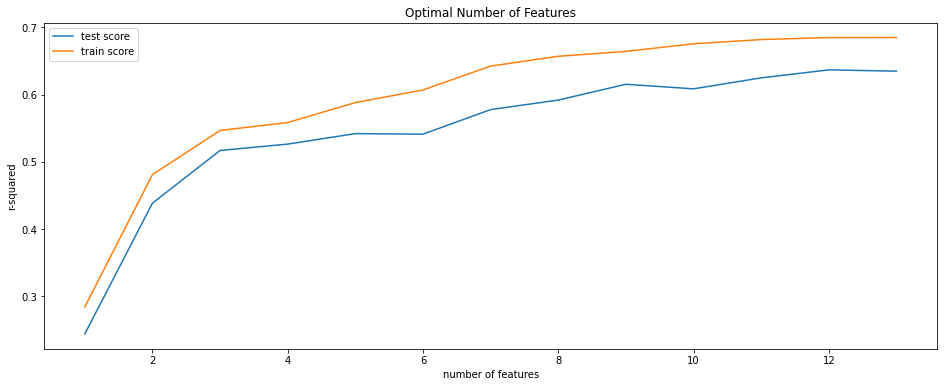

In [37]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

Now we can choose the optimal value of number of features and build a final model.

In [38]:
# final model
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5995575338728529


Notice that the test score is very close to the 'mean test score' on the k-folds (about 60%). In general, the mean score estimated by CV will usually be a good estimate of the test score. 

### Now using Another Example: Car Price Prediction

In [42]:
# reading the dataset
cars = pd.read_csv("CarPrice_Assignment.csv")

In [43]:
# All data preparation steps in this cell

# converting symboling to categorical
cars['symboling'] = cars['symboling'].astype('object')


# create new column: car_company
p = re.compile(r'\w+-?\w+')
cars['car_company'] = cars['CarName'].apply(lambda x: re.findall(p, x)[0])


# replacing misspelled car_company names
# volkswagen
cars.loc[(cars['car_company'] == "vw") | 
         (cars['car_company'] == "vokswagen")
         , 'car_company'] = 'volkswagen'
# porsche
cars.loc[cars['car_company'] == "porcshce", 'car_company'] = 'porsche'
# toyota
cars.loc[cars['car_company'] == "toyouta", 'car_company'] = 'toyota'
# nissan
cars.loc[cars['car_company'] == "Nissan", 'car_company'] = 'nissan'
# mazda
cars.loc[cars['car_company'] == "maxda", 'car_company'] = 'mazda'


# drop carname variable
cars = cars.drop('CarName', axis=1)


# split into X and y
X = cars.loc[:, ['symboling', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber',
       'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'car_company']]
y = cars['price']


# creating dummy variables for categorical variables
cars_categorical = X.select_dtypes(include=['object'])
cars_categorical.head()


# convert into dummies
cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)
cars_dummies.head()


# drop categorical variables 
X = X.drop(list(cars_categorical.columns), axis=1)


# concat dummy variables with X
X = pd.concat([X, cars_dummies], axis=1)


# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols


# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [44]:
# number of features
len(X_train.columns)

68

In [45]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:   12.4s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [46]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.083219,0.005708,0.002800,3.999958e-04,2,{'n_features_to_select': 2},7.123223e-01,0.673284,0.839691,0.643727,...,7.169718e-01,6.686748e-02,30,0.693638,0.809346,0.768171,0.798515,0.798908,0.773715,0.042337
1,0.077772,0.004357,0.002927,5.229597e-04,3,{'n_features_to_select': 3},8.175681e-01,0.720574,0.864579,0.675851,...,7.041905e-01,1.471020e-01,33,0.796890,0.868796,0.833999,0.850420,0.845840,0.839189,0.023930
2,0.078663,0.008439,0.002600,4.899404e-04,4,{'n_features_to_select': 4},8.294134e-01,0.812420,0.862303,0.735701,...,7.369906e-01,1.517419e-01,28,0.834392,0.904158,0.894407,0.881821,0.850000,0.872956,0.026557
3,0.077820,0.006084,0.003005,6.332600e-04,5,{'n_features_to_select': 5},6.692111e-01,0.814914,0.864962,0.768708,...,7.107409e-01,1.518250e-01,32,0.863963,0.907896,0.897645,0.911010,0.895627,0.895228,0.016692
4,0.079895,0.004282,0.002998,5.479687e-06,6,{'n_features_to_select': 6},6.751739e-01,0.811662,0.871892,0.764830,...,7.130437e-01,1.501486e-01,31,0.864405,0.908017,0.902980,0.912918,0.909751,0.899614,0.017896
5,0.082733,0.005155,0.002998,6.365603e-04,7,{'n_features_to_select': 7},6.192412e-01,0.815732,0.853156,0.765352,...,7.205156e-01,1.168854e-01,29,0.875107,0.908596,0.915144,0.914559,0.926074,0.907896,0.017338
6,0.082926,0.008681,0.003201,4.002105e-04,8,{'n_features_to_select': 8},6.083477e-01,0.861613,0.853156,0.763983,...,7.766328e-01,9.158049e-02,24,0.887177,0.926444,0.915144,0.914797,0.930265,0.914766,0.015086
7,0.078017,0.006035,0.003201,3.998533e-04,9,{'n_features_to_select': 9},6.382068e-01,0.868169,0.856988,0.763969,...,7.822735e-01,8.252704e-02,20,0.889975,0.929960,0.917605,0.914826,0.934186,0.917310,0.015481
8,0.076418,0.001018,0.002999,1.754605e-06,10,{'n_features_to_select': 10},6.378112e-01,0.871081,0.841094,0.763966,...,7.838200e-01,8.131718e-02,19,0.889975,0.932598,0.925131,0.914828,0.939454,0.920397,0.017268
9,0.074618,0.001625,0.003200,4.000666e-04,11,{'n_features_to_select': 11},6.378112e-01,0.849864,0.860012,0.684470,...,7.690200e-01,9.067412e-02,26,0.889975,0.935176,0.936501,0.924168,0.940519,0.925268,0.018459


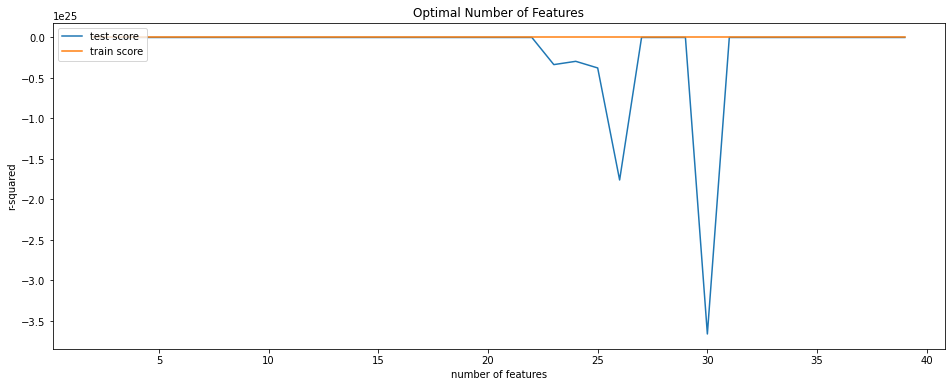

In [47]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')